In [1]:
import warnings; warnings.filterwarnings("ignore") # remove scanpy warnings for the tutorial.

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scanpy as sc

In [3]:
import decipher as dc
dc.pl.activate_journal_quality()

### Load the data

In [4]:
color_palette = None

# Load the AnnData (available at https://github.com/azizilab/decipher_data/data_decipher_tutorial.h5ad)
adata = sc.read_h5ad(f"../data_decipher_tutorial.h5ad")
color_palette = adata.uns["color_palette"]

In [5]:
# Perform any filtering of cells or genes, but retain raw counts

adata = adata[~adata.obs["cell_type"].isin(["mep", "ery", "lympho"])]

### Train Decipher

Epoch 24 | train elbo: 3482.00 | val ll: 3471.21:  24%|███████████████████████                                                                         | 24/100 [03:15<10:19,  8.15s/it]2023-11-15 17:39:56,223 | INFO : Early stopping has been triggered.
2023-11-15 17:39:56,700 | INFO : Added `.obsm['decipher_v']`: the Decipher v space.
2023-11-15 17:39:56,701 | INFO : Added `.obsm['decipher_z']`: the Decipher z space.
2023-11-15 17:39:56,709 | INFO : Saving decipher model with run_id 2023-11-15-17-39-56-golden-rosy-noodle.


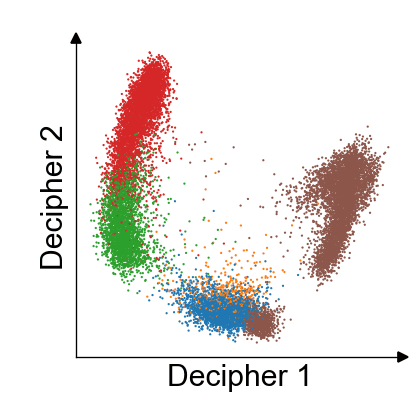

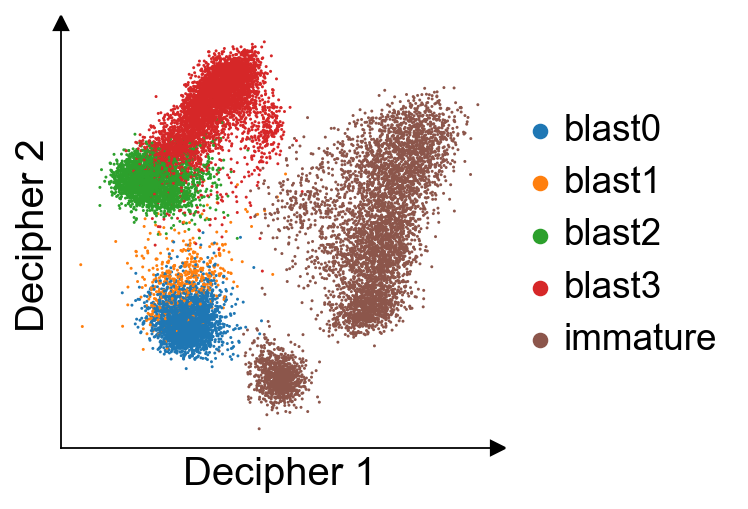

In [6]:
decipher_config = dc.tl.DecipherConfig() # optional Decipher config

d1, val1 = dc.tl.decipher_train(
    adata, decipher_config, plot_kwargs={"color": "cell_type", "palette": color_palette}, plot_every_k_epochs=5,
)

### Rotate and flip the learned latent space to align it with the mechanisms of interest
We would ideally want `Decipher 1` to capture blast progression, and `Decipher 2` to discriminate `Healthy` and the AML sample.

2023-11-15 17:39:57,813 | INFO : Added `.obsm['decipher_v']`: the Decipher v space.
2023-11-15 17:39:57,813 | INFO : Added `.obsm['decipher_z']`: the Decipher z space.


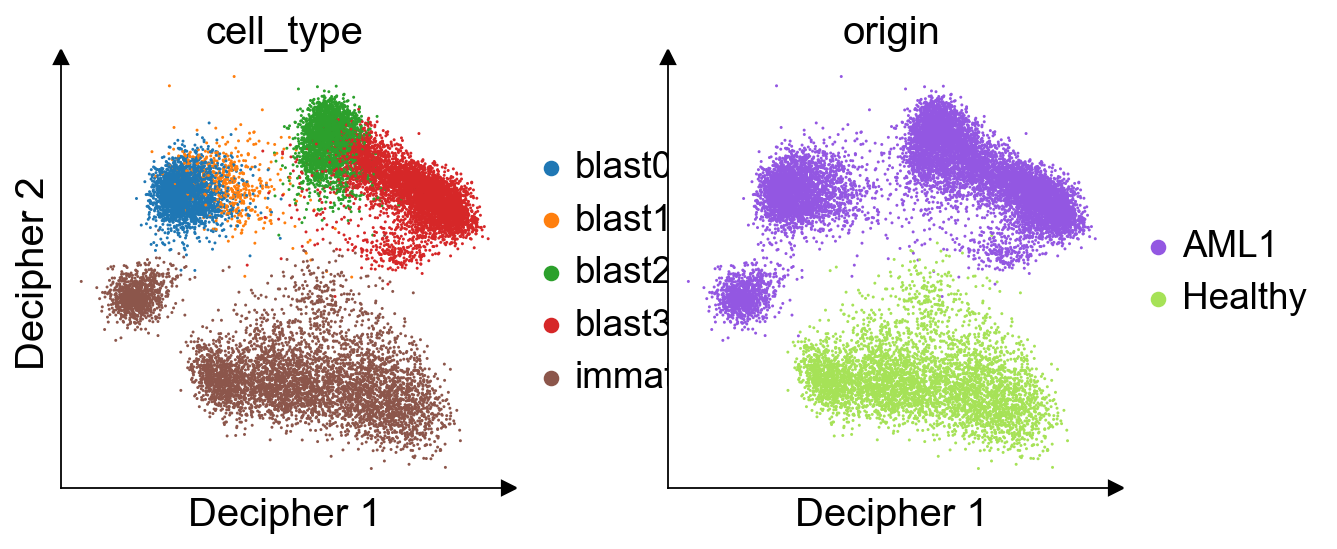

In [7]:
dc.tl.decipher_rotate_space(
    adata,
    v1_col="cell_type",
    v1_order=["blast0", "blast1", "blast2", "blast3"],
    v2_col="origin",
    v2_order=["Healthy", "AML1"],
)
dc.pl.decipher(adata, ["cell_type", "origin"], palette=color_palette);

### We now cluster the cells using the `decipher_z` representation, and compute trajectories.

2023-11-15 17:39:58,766 | INFO : Clustering cells using scanpy Leiden algorithm.
2023-11-15 17:39:58,767 | INFO : Step 1: Computing neighbors with `sc.pp.neighbors`, with the representation decipher_z.
2023-11-15 17:40:17,462 | INFO : Step 2: Computing clusters with `sc.tl.leiden`, and resolution 1.0.
2023-11-15 17:40:21,457 | INFO : Added `.obs['decipher_clusters']`: the cluster labels.


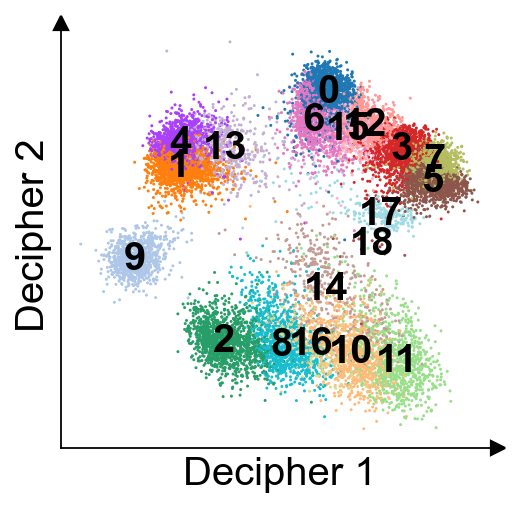

In [8]:
dc.tl.cell_clusters(adata)
dc.pl.decipher(adata, ["decipher_clusters"], legend_loc="on data");

2023-11-15 17:40:21,887 | INFO : Trajectory Healthy : ['2', '8', '16', '10', '11'])
2023-11-15 17:40:21,891 | INFO : Added trajectory Healthy to `adata.uns['decipher']['trajectories']`.
2023-11-15 17:40:21,998 | INFO : Trajectory AML1 : ['9', '1', '4', '13', '6', '15', '12', '3', '7', '5'])
2023-11-15 17:40:22,005 | INFO : Added trajectory AML1 to `adata.uns['decipher']['trajectories']`.


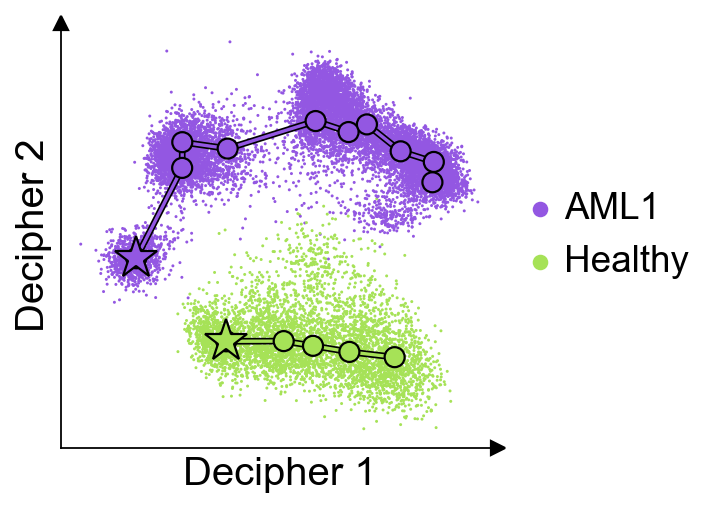

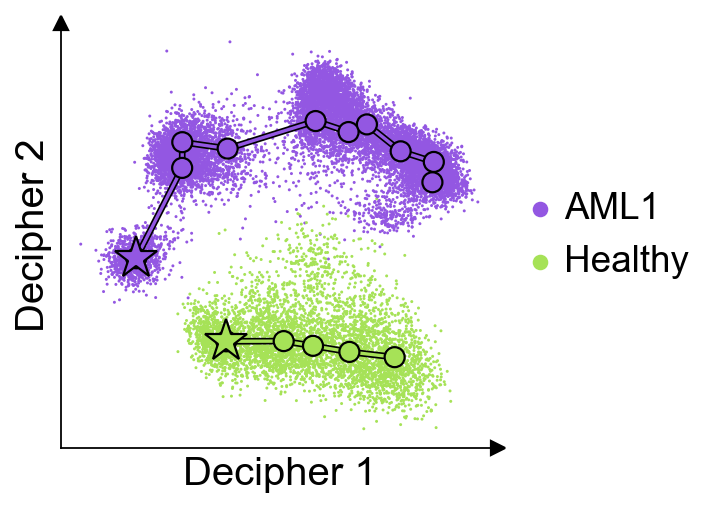

In [9]:
dc.tl.trajectories(
    adata,
    dc.tl.TConfig("Healthy", "AVP", "MPO", "origin", "Healthy"),
    dc.tl.TConfig("AML1", "AVP", "CD68", "origin", "AML1"),
)
dc.pl.trajectories(adata, "origin", palette=color_palette)

2023-11-15 17:40:22,530 | INFO : Added `.obs['decipher_time']`: the decipher time of each cell.


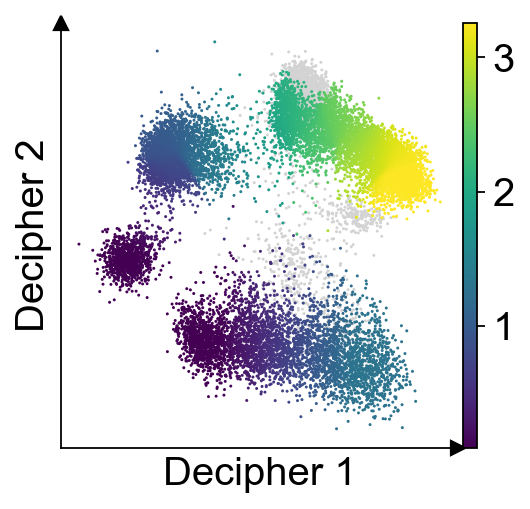

In [10]:
dc.tl.decipher_time(adata)
dc.pl.decipher_time(adata);

### Compute gene patterns

In [11]:
dc.tl.gene_patterns(adata)

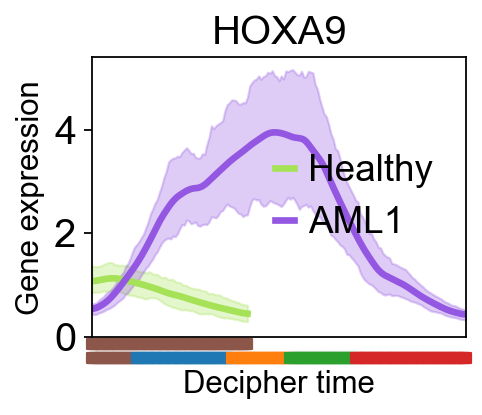

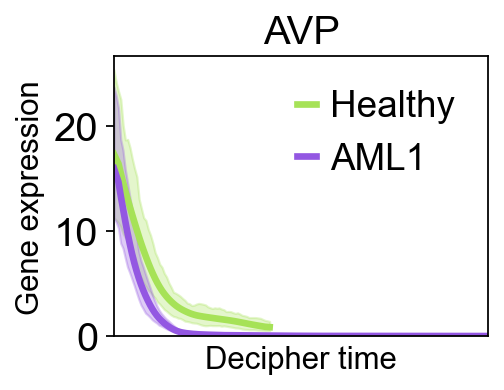

In [12]:
dc.pl.gene_patterns(adata, "HOXA9", palette=color_palette, cell_type_key="cell_type")
dc.pl.gene_patterns(adata, "AVP", palette=color_palette);

### Compute basis decomposition

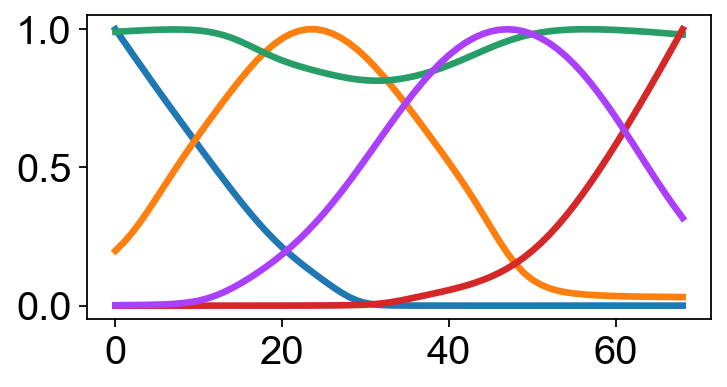

Loss: -966499.6 - Relative Error: 0.13%:  47%|███████████████████████████████████████████████▎                                                     | 4680/10000 [03:12<03:38, 24.31it/s]


In [13]:
training_losses = dc.tl.basis_decomposition(adata, seed=0);

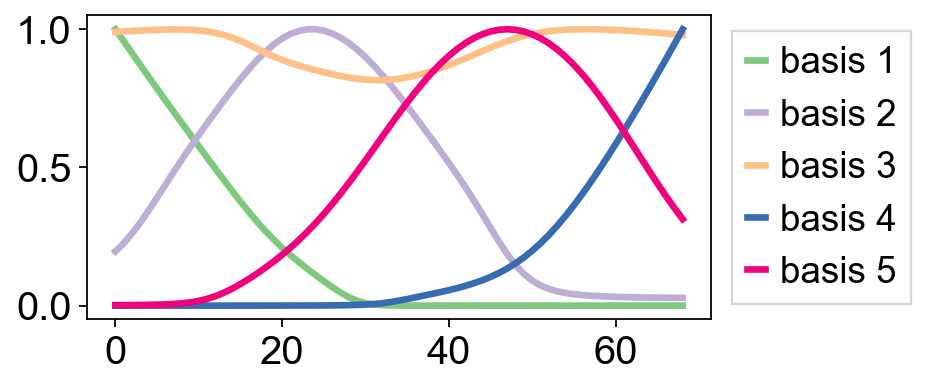

In [14]:
colors = [sns.color_palette("Accent")[i] for i in [0, 1, 2, 4, 5]]
dc.pl.basis(adata, colors=colors);

In [15]:
dc.tl.disruption_scores(adata)
adata.var[[c for c in adata.var if "decipher_disruption" in c]].sort_values(
    "decipher_disruption_combined", ascending=False
).head(10)

2023-11-15 17:43:38,551 | INFO : Added `.var['decipher_disruption_shape']`: shape disruption scores
2023-11-15 17:43:38,552 | INFO : Added `.var['decipher_disruption_scale']`: scale disruption scores
2023-11-15 17:43:38,552 | INFO : Added `.var['decipher_disruption_combined']`: combined disruption scores
2023-11-15 17:43:38,557 | INFO : Added `.uns['decipher']['disruption_scores']`: disruption scores
2023-11-15 17:43:38,558 | INFO : Added `.uns['decipher']['disruption_scores_samples']`: disruption scores probabilistic samples


decipher_disruption_shape  decipher_disruption_scale  \
index                                                           
C1QTNF4                   0.585618                   2.450126   
DNTT                      0.711000                   5.786712   
CMTM8                     0.341335                   0.918616   
IGLL1                     0.481286                   2.751904   
UBE2C                     0.674537                   2.519647   
BIRC5                     0.701430                   2.449044   
RRM2                      0.665228                   2.000454   
MPO                       0.132185                   2.681761   
ICAM1                     0.643572                   3.076092   
CDK1                      0.624961                   2.133272   

         decipher_disruption_combined  
index                                  
C1QTNF4                     14.667301  
DNTT                        14.262213  
CMTM8                       12.359250  
IGLL1                       11.971736  
UBE2C                       11.882829  
BIRC5                       11.882485  
RRM2                        11.676637  
MPO                         11.662468  
ICAM1                       11.581854  
CDK1                        11.537175

## Other figures

In [16]:
plt.rcParams["figure.figsize"] = [3,3]

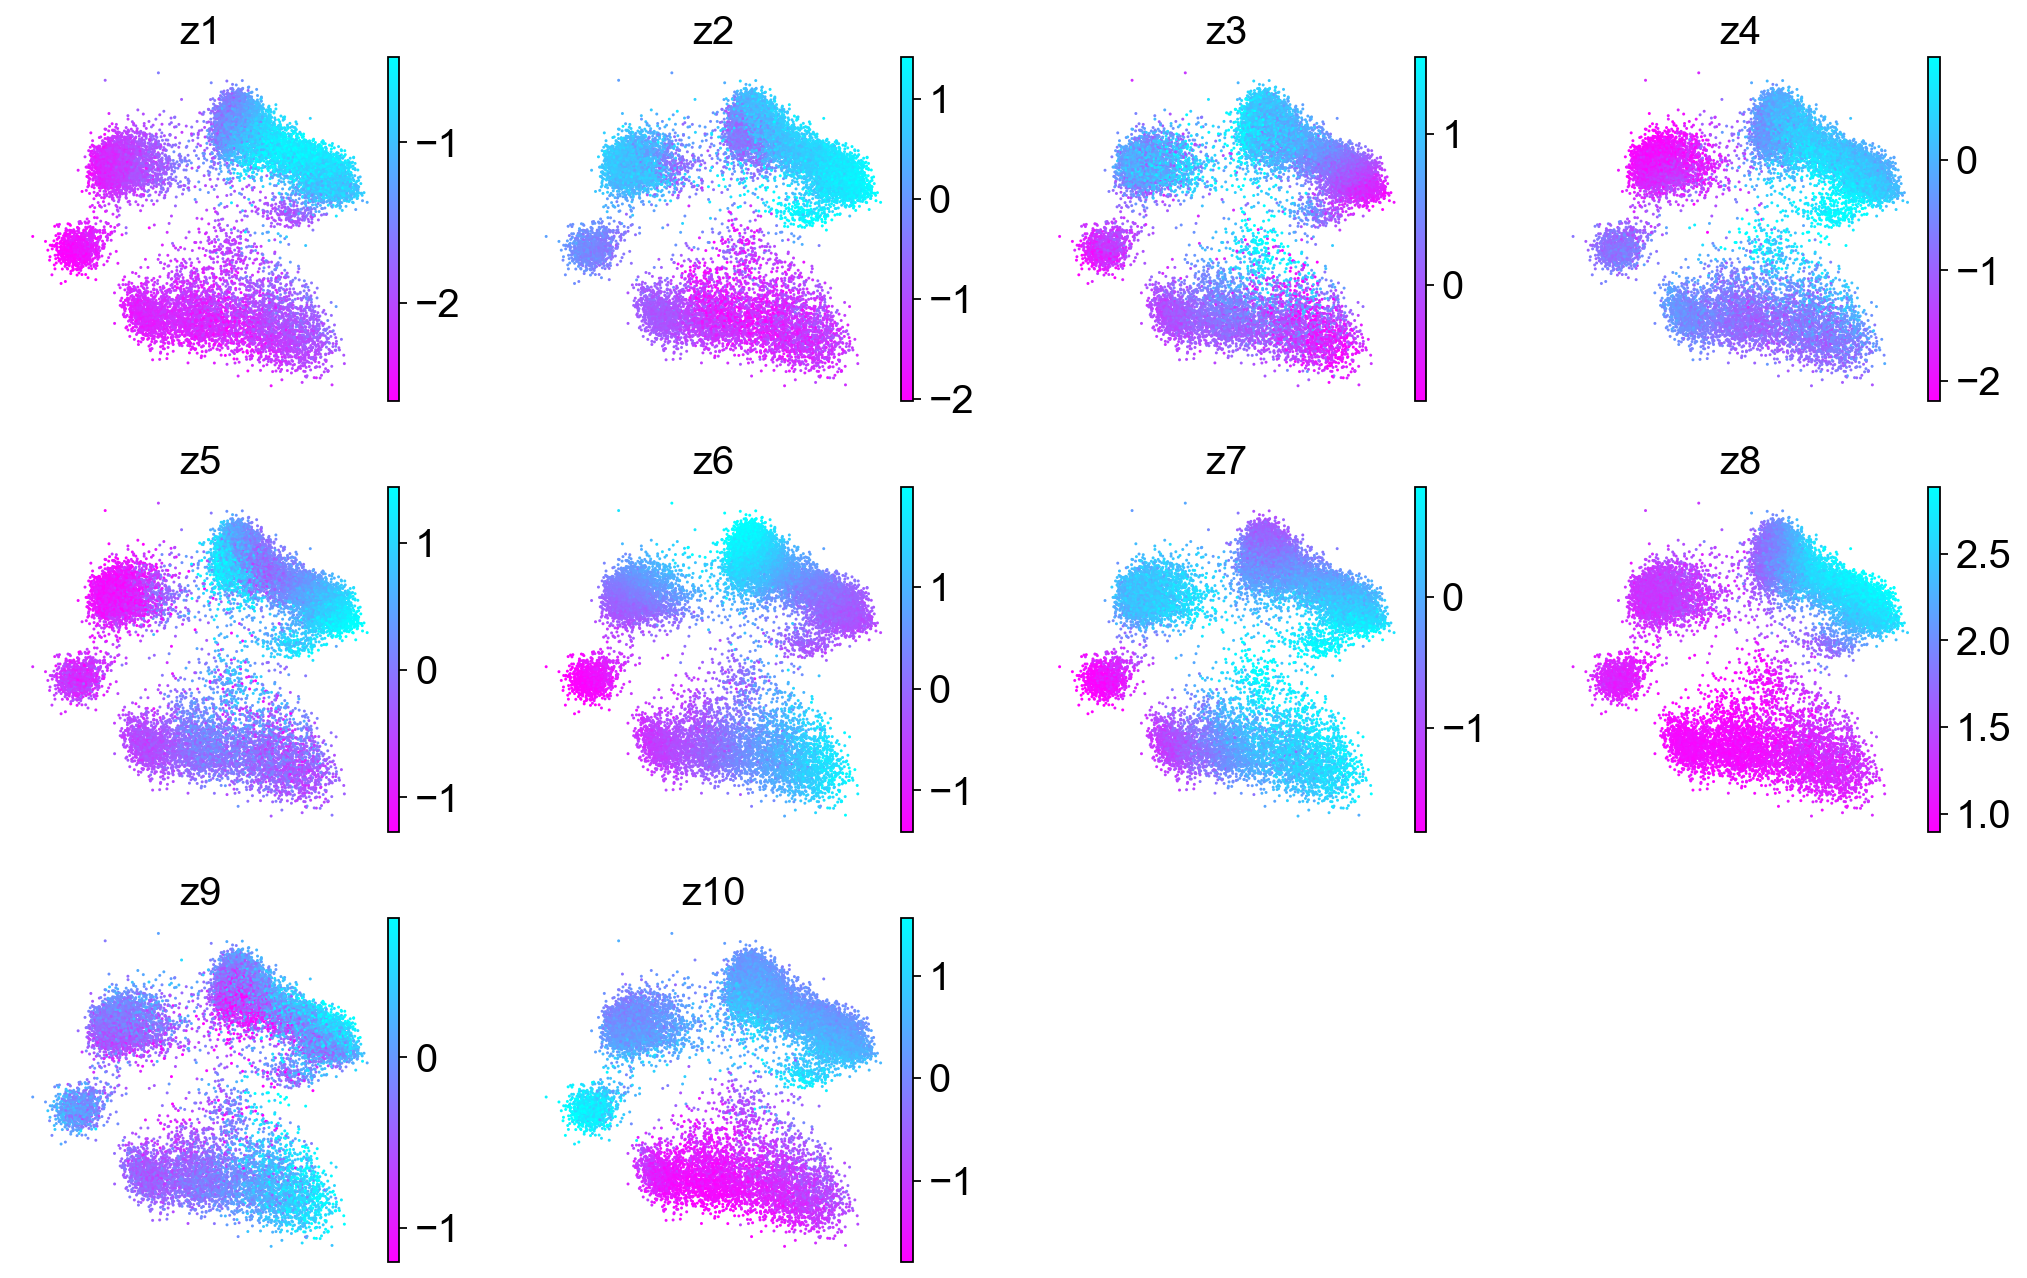

In [17]:
dc.pl.decipher_z(adata);

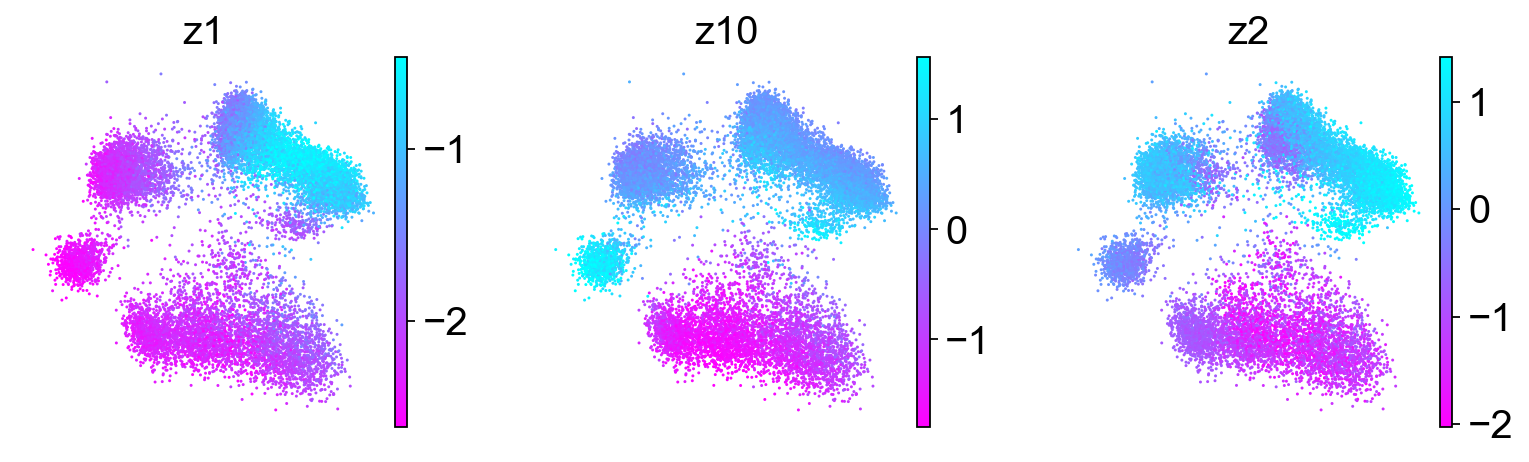

In [18]:
fig = dc.pl.decipher_z(adata, subset_of_zs=[1,10,2]);

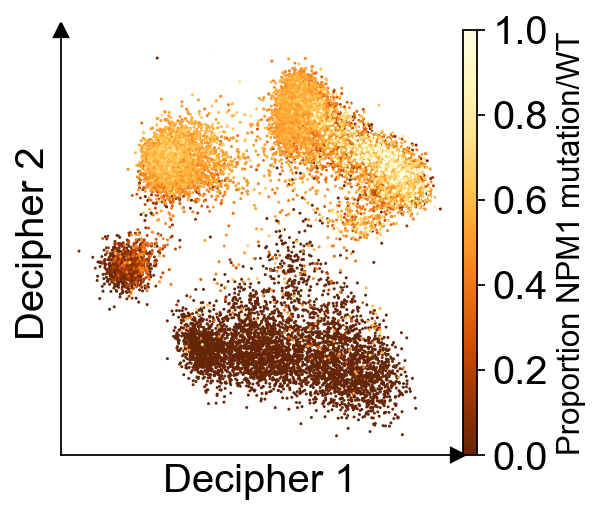

In [19]:
fig = dc.pl.decipher(adata, "NPM1 mutation vs wild type", cmap=sns.color_palette("YlOrBr_r", as_cmap=True, ))
fig.axes[0].collections[-1].colorbar.set_label("Proportion NPM1 mutation/WT", fontsize=14)


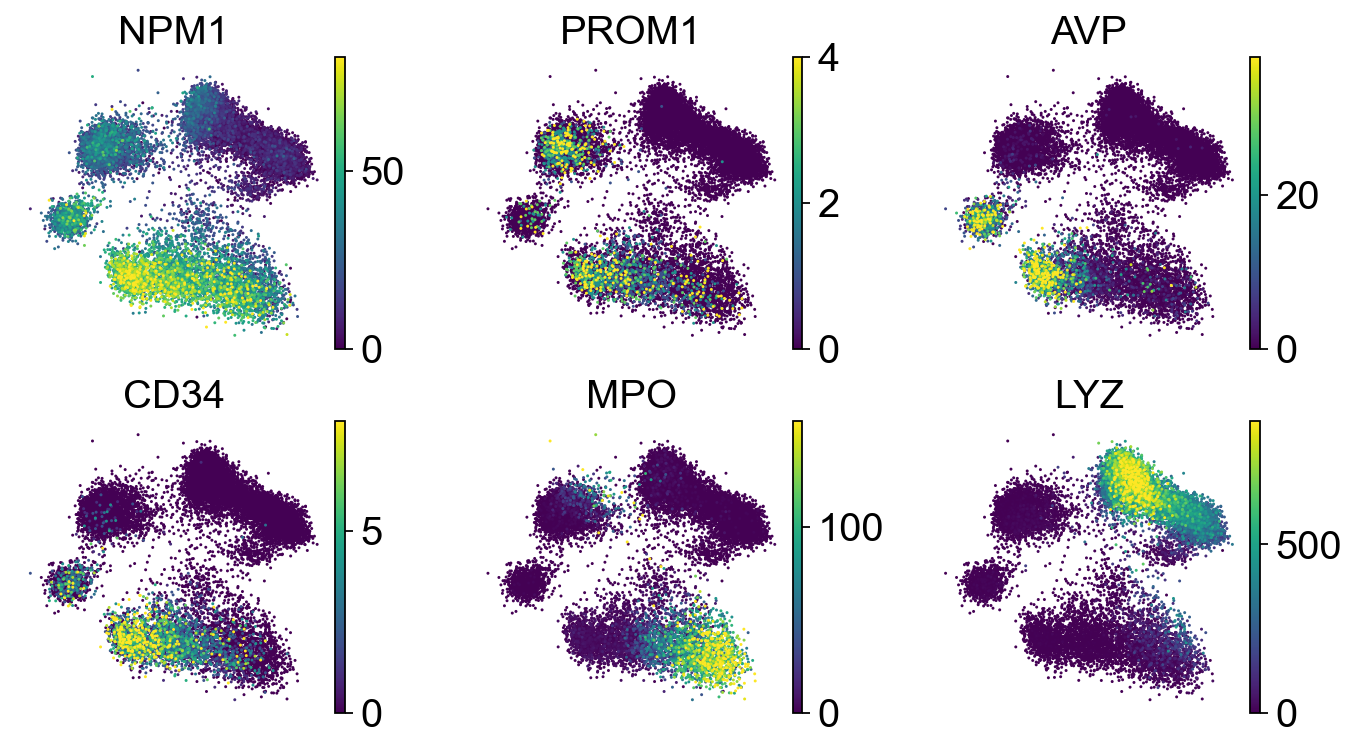

In [20]:
dc.pl.decipher(
    adata,
    ["NPM1", "PROM1", "AVP", "CD34", "MPO", "LYZ"],
    ncols=3,
    vmax=lambda x: np.quantile(x, 0.99),
    figsize=(2.5, 2.5),
    axis_type=None
);